In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torchvision.datasets

#### Get data

In [2]:
MNIST_TRAIN = torchvision.datasets.MNIST(root='./', train=True, download=True)
MNIST_TEST = torchvision.datasets.MNIST(root='./', train=False, download=True)

In [3]:
X_train, y_train = MNIST_TRAIN.data, MNIST_TRAIN.targets

In [4]:
X_test, y_test = MNIST_TEST.data, MNIST_TEST.targets

In [5]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

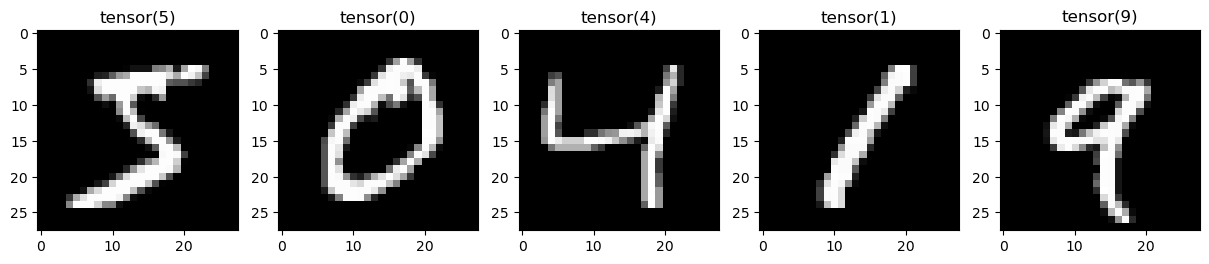

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].title.set_text(y_train[i])
plt.show();

In [7]:
X_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

#### Define base FC model (without conv)

In [8]:
class FcModel(nn.Module):
    def __init__(self, num_features = 28 * 28, hidden = 200, num_classes = 10):
        super().__init__()
        self.fc1 = nn.Linear(num_features, hidden)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, num_classes)
    
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

#### Make dataloader

In [9]:
from torch.utils.data import DataLoader, TensorDataset

In [10]:
X_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [11]:
X_train, X_test = X_train.to(torch.float16), X_test.to(torch.float16)
y_train, y_test = y_train.to(torch.uint8), y_test.to(torch.uint8)


In [12]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, pin_memory=True, shuffle=True, num_workers=4)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, pin_memory=True, shuffle=True, num_workers=4)

#### Pre-train details

In [13]:
def acc_fn(y_true, y_preds):
    if y_true.shape != y_preds.shape:
        return ValueError("Wrong shapes y_true and y_preds")
    return torch.sum(y_true == y_preds) / len(y_true)

In [14]:
def train_func(model_class, tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4):
    
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    model = model_class().half().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.7)
    
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        
        for X, y in tr_l:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(tr_l)
        train_loss_hist.append(train_loss)

        
        if epoch % (epochs // 10) == 0:
            
            model.eval()
            test_loss = 0
            test_acc = 0
            
            with torch.no_grad():
                for X, y in ts_l:
                    X, y = X.to(device), y.to(device)
                    preds = model(X)
                    test_loss += loss_fn(preds, y).item()
                    test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()
            
            test_loss /= len(ts_l)
            test_acc /= len(ts_l)
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            
            print(
                f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"
            )
    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
trained_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(FcModel, train_loader, 
                                                            test_loader, loss_fn, 
                                                            acc_fn, device, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	train loss: 0.279541015625	test loss:0.32452624357199367	test acc:0.9089200949367089
Epoch: 1	train loss: 0.39697265625	test loss:0.2562132243868671	test acc:0.9276107594936709
Epoch: 2	train loss: 0.1761474609375	test loss:0.22193387188488925	test acc:0.9376977848101266
Epoch: 3	train loss: 0.262939453125	test loss:0.21286899228639242	test acc:0.9401700949367089
Epoch: 4	train loss: 0.2000732421875	test loss:0.19030993497824367	test acc:0.9443235759493671
Epoch: 5	train loss: 0.037078857421875	test loss:0.1813192246835443	test acc:0.9454113924050633
Epoch: 6	train loss: 0.1307373046875	test loss:0.17248766935324367	test acc:0.9492681962025317
Epoch: 7	train loss: 0.046905517578125	test loss:0.16400571412678006	test acc:0.9529272151898734
Epoch: 8	train loss: 0.17138671875	test loss:0.16062907931170886	test acc:0.9527294303797469
Epoch: 9	train loss: 0.033782958984375	test loss:0.15684219553500792	test acc:0.952432753164557


In [17]:
def plot_train_func(train_loss_hist, test_loss_hist, test_acc_hist):
    d = {
        0 : train_loss_hist,
        1 : test_loss_hist,
        2 : test_acc_hist
	}
    names = {
        0 : "Train loss",
        1 : "Test loss",
        2 : "Test accuracy"
    }
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    for i in range(3):
        ax[i].plot(d[i])
        ax[i].grid()
        ax[i].set_title(names[i])
    plt.show();

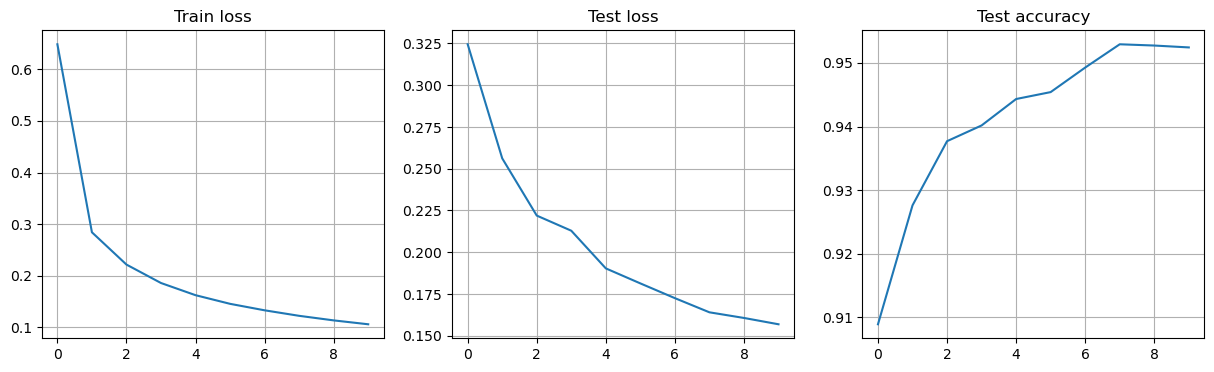

In [18]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

In [20]:
import gc
gc.collect()

torch.mps.empty_cache()

#### Now let's try Conv net

In [21]:
class ConvNet(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10, hidden = 384):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        
        
        self.seq1 = nn.Sequential(
			nn.Conv2d(in_channels, 6, 3, padding=1), # 28 -> 28
            self.relu,
            nn.BatchNorm2d(6),
			nn.MaxPool2d(2, 2) # 28 -> 14
		)
        
        self.seq2 = nn.Sequential(
			nn.Conv2d(6, 16, 3, padding=1), # 14 -> 14
            self.relu,
            nn.BatchNorm2d(16),
			nn.MaxPool2d(2, 2) # 14 -> 7
		)
        self.fc1 = nn.Linear(7 * 7 * 16, hidden)
        self.bn = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(dim = 1)
        x = self.seq1(x)
        x = self.seq2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.bn(x)
        x = self.fc2(x)
        return x

In [22]:
model, conv_tr_loss_hist, conv_ts_loss_hist, conv_ts_acc_hist = train_func(
    ConvNet, train_loader, test_loader, loss_fn, acc_fn, device, 10, 3e-3
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	train loss: 0.1771240234375	test loss:0.07745844201196599	test acc:0.9793314873417721
Epoch: 1	train loss: 0.038360595703125	test loss:0.056041476092761076	test acc:0.9840783227848101
Epoch: 2	train loss: 0.03411865234375	test loss:0.04701387429539161	test acc:0.9861550632911392
Epoch: 3	train loss: 0.01374053955078125	test loss:0.04039880293834058	test acc:0.9875395569620253
Epoch: 4	train loss: 0.030303955078125	test loss:0.04031536247156843	test acc:0.9864517405063291
Epoch: 5	train loss: 0.01171875	test loss:0.03558071957358831	test acc:0.9890229430379747
Epoch: 6	train loss: 0.08648681640625	test loss:0.03405467166176325	test acc:0.9887262658227848
Epoch: 7	train loss: 0.0102691650390625	test loss:0.03426645979096618	test acc:0.9893196202531646
Epoch: 8	train loss: 0.0097808837890625	test loss:0.034606064422221125	test acc:0.9892207278481012
Epoch: 9	train loss: 0.02294921875	test loss:0.03374761267553402	test acc:0.9883306962025317


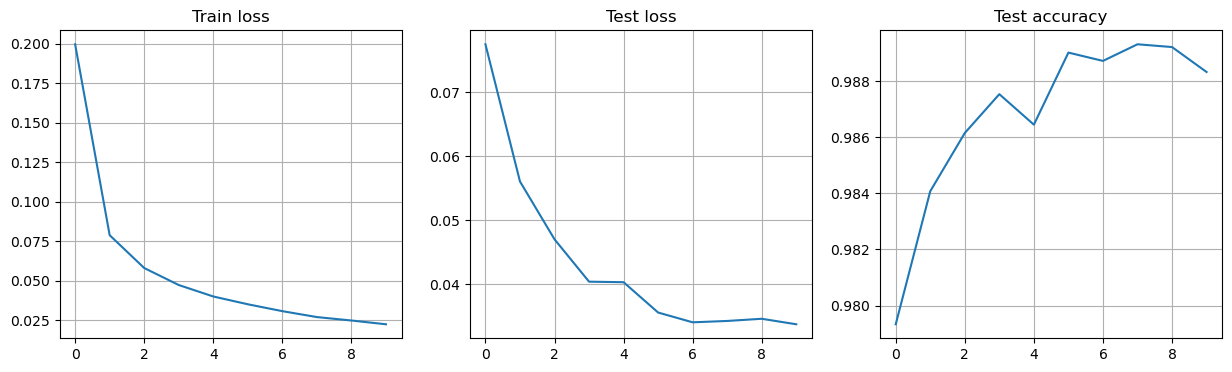

In [23]:
plot_train_func(conv_tr_loss_hist, conv_ts_loss_hist, conv_ts_acc_hist)

#### As we can observe, ConvNet trained faster on our data and showed much better accuracy compared to the full-connected neural network